# Notebook 1 (v2) — Implied Risk-Neutral Distribution with Spline Derivatives

This notebook computes the **risk‑neutral probability distribution** of the terminal price \(S_T\) from a single day’s option chain using the Breeden–Litzenberger idea:
  
- \(C(K) = D\,\mathbb{E}[(S_T - K)^+]\)  ⇒  \(-\partial C/\partial K = D\,\mathbb{Q}(S_T > K)\)  ⇒  \(\partial^2 C/\partial K^2 = D\,f_{S_T}(K)\).  
- We recover the **PDF** as \(f_{S_T}(K) = D^{-1} C''(K)\), after cleaning the call curve so it is **decreasing** and **convex** in strike \(K\).

### What you’ll see
1. **Data ingest:** fetch a single expiry via `yfinance` (or use the included `sample_chain.csv` if offline).
2. **Forward & discount:** infer \(F_T\) and \(D=e^{-rT}\) from put–call parity with a robust linear fit.
3. **No‑arbitrage cleaning:** project call prices onto the cone {decreasing & convex in \(K\)} to remove butterfly arbitrage.
4. **Implied CDF/PDF:** compute first/second strike derivatives, clip tiny negatives, renormalize, and verify moments.
5. **Plots & diagnostics:** raw vs cleaned calls, tail probability, PDF vs a matched lognormal, and a small metrics table.

> **Tip:** Run this notebook end‑to‑end on a single expiry for **SPY** to keep data small and compute instantaneous.


This version uses a **regularized convex fit** and a **cubic spline** for derivatives to avoid spiky PDFs.

In [45]:
# %pip install yfinance numpy pandas scipy matplotlib cvxpy nbformat

In [46]:
import numpy as np, pandas as pd, numpy.linalg as LA, matplotlib.pyplot as plt, math, warnings
try:
    import yfinance as yf; HAVE_YF=True
except Exception:
    HAVE_YF=False
try:
    import cvxpy as cp; HAVE_CVXPY=True
except Exception:
    HAVE_CVXPY=False
from scipy import optimize, interpolate
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda v: f'{v:,.6f}')

## 1) Configuration (ticker & expiry)

In [ ]:
TICKER="SPY"; EXPIRY=None ; SAMPLE_CSV=r"/mnt/data/sample_chain.csv"
KEEP_FWD_MULT=(0.7,1.3); LAMBDA_REG=1e-2; SPLINE_S=None; SPLINE_K=3; GRID_POINTS=161

## 2) Data ingest (live via `yfinance`, else offline sample)

We try to:
- Pull the option chain for a **single expiry**.
- Compute **mid quotes** for calls (and puts if available).
- Restrict to a strike band around the forward to reduce edge artifacts.


In [48]:
def fetch_chain_yf(ticker:str, expiry:str|None):
    if not HAVE_YF: return None
    try:
        tk=yf.Ticker(ticker); exps=tk.options
        if not exps: return None
        exp=expiry or exps[0]; oc=tk.option_chain(exp)
        calls=oc.calls.copy(); puts=oc.puts.copy() if oc.puts is not None else None
        calls['call_mid']=(calls['bid'].fillna(0)+calls['ask'].fillna(0))/2
        calls=calls[['strike','call_mid','bid','ask','impliedVolatility','openInterest']].rename(
            columns={'strike':'K','impliedVolatility':'iv','openInterest':'oi','bid':'call_bid','ask':'call_ask'})
        if puts is not None and len(puts):
            puts['put_mid']=(puts['bid'].fillna(0)+puts['ask'].fillna(0))/2
            puts=puts[['strike','put_mid']].rename(columns={'strike':'K'})
            df=pd.merge(calls, puts, on='K', how='left')
        else:
            df=calls
        df['expiry']=exp
        return df.sort_values('K').reset_index(drop=True)
    except Exception:
        return None

def load_sample(path:str):
    df=pd.read_csv(path)
    keep=[c for c in ['K','call_mid','put_mid','call_bid','call_ask','expiry'] if c in df.columns]
    return df[keep].sort_values('K').reset_index(drop=True)

df_raw=fetch_chain_yf(TICKER, EXPIRY)
if df_raw is None or df_raw['call_mid'].fillna(0).sum()==0: 
    df_raw=load_sample(SAMPLE_CSV); source='sample_csv'
else: source='yfinance'
print('source:',source,'rows:',len(df_raw)); df_raw.head(5)

source: yfinance rows: 151


,K,call_mid,call_bid,call_ask,iv,oi,put_mid,expiry
0,325.000000,327.060000,325.600000,328.520000,1.065190,1,0.025000,2025-10-17
1,330.000000,322.060000,320.600000,323.520000,1.044194,4,0.025000,2025-10-17
2,340.000000,312.095000,310.610000,313.580000,1.007085,2,0.035000,2025-10-17
3,350.000000,302.125000,300.630000,303.620000,0.970215,4,0.035000,2025-10-17
4,355.000000,297.075000,295.630000,298.520000,0.944581,17,0.045000,2025-10-17


## 3) Infer forward \(F_T\) and discount \(D=e^{-rT}\) via put–call parity

At a fixed expiry \(T\), for each strike \(K\):
\[
C(K) - P(K) \;=\; D\,(F_T - K).
\]
Thus a **robust linear regression** of \(Y=C-P\) against \(X=K\) gives:
- slope \(\hat\beta_1 \approx -D\)
- intercept \(\hat\beta_0 \approx D\,F_T\)  
⇒ \(\hat D=-\hat\beta_1,\ \ \hat F_T=\hat\beta_0/\hat D\).

If puts are missing, we fall back to **short‑dated** assumption \(D\approx 1\) and set \(F_T\) from spot (if available) or the strike minimizing call moneyness.

In [49]:
def infer_forward_discount(df:pd.DataFrame):
    have_puts='put_mid' in df.columns and df['put_mid'].notna().sum()>5
    if have_puts:
        m=df['call_mid'].notna() & df['put_mid'].notna()
        y=(df.loc[m,'call_mid']-df.loc[m,'put_mid']).values
        X=df.loc[m,'K'].values
        A=np.vstack([np.ones_like(X),X]).T
        a,b=LA.lstsq(A,y,rcond=None)[0]
        D=max(1e-9,-b); F=a/D
    else:
        D=1.0; idx=np.nanargmin(np.abs(np.diff(df['call_mid'], prepend=df['call_mid'].iloc[0]))); F=float(df['K'].iloc[int(np.clip(idx,0,len(df)-1))])
    return float(F), float(D)

F_T, D = infer_forward_discount(df_raw); print('F_T=',F_T,' D=',D)

F_T= 653.2158900095583  D= 0.9902640586114632


## 4) Restrict to a forward-centered strike band and resample to a **uniform** grid

We keep strikes in \([\alpha F_T, \beta F_T]\) to reduce edge noise, then interpolate call mids to a uniform grid (central differences behave better on uniform spacing).

In [50]:
def restrict_uniform(df, F_T, keep_mult=(0.7,1.3), n_points=161):
    lo,hi=keep_mult; kmin,kmax=F_T*lo,F_T*hi
    d=df[(df['K']>=kmin)&(df['K']<=kmax)].copy().dropna(subset=['call_mid'])
    if len(d)<25: d=df.copy().dropna(subset=['call_mid'])
    K=np.linspace(d['K'].min(), d['K'].max(), n_points)
    C=np.interp(K, d['K'].values, d['call_mid'].values)
    out=pd.DataFrame({'K':K,'call_mid':C})
    if 'put_mid' in d.columns: out['put_mid']=np.interp(K, d['K'].values, d['put_mid'].values)
    return out
df_uni=restrict_uniform(df_raw, F_T, keep_mult=KEEP_FWD_MULT, n_points=GRID_POINTS); print('grid size',len(df_uni))

grid size 161


## 5) No‑arbitrage cleaning in strike: decreasing & convex

For a fixed \(T\), the call price as a function of strike \(C(K)\) must satisfy:
- **Monotone:** \(C_{i+1}-C_i \le 0\) (decreasing in \(K\)).
- **Convex:** \(C_{i+1}-2C_i+C_{i-1} \ge 0\) (on a uniform grid).

We project the raw vector \(\mathbf{c}\) onto this **convex‑decreasing cone** by solving the small QP:
\[
\min_{\hat{\mathbf{c}}}\ \|\hat{\mathbf{c}}-\mathbf{c}\|_2^2
\quad \text{s.t.}\quad
D_1\,\hat{\mathbf{c}} \le 0,\ \ D_2\,\hat{\mathbf{c}}\ge 0,
\]
where \(D_1\) and \(D_2\) are first and second‑difference matrices.

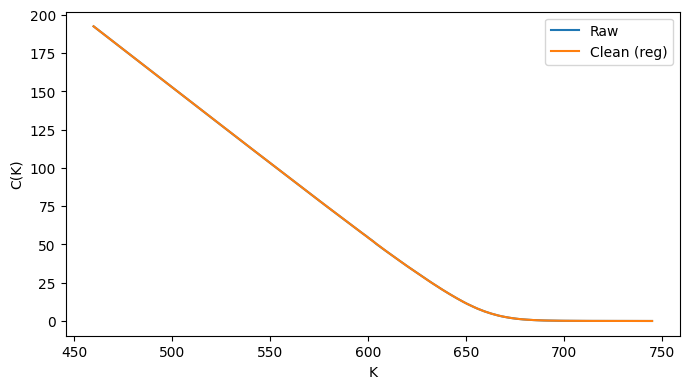

In [51]:
def diff_mats(n):
    D1=np.zeros((n-1,n)); 
    for i in range(n-1): D1[i,i]=-1.0; D1[i,i+1]=1.0
    D2=np.zeros((n-2,n)); 
    for i in range(n-2): D2[i,i]=1.0; D2[i,i+1]=-2.0; D2[i,i+2]=1.0
    return D1,D2

def convex_monotone_fit_reg(c, lambda_reg=1e-2):
    c=np.asarray(c,dtype=float); n=c.size; D1,D2=diff_mats(n)
    try:
        import cvxpy as cp
        C=cp.Variable(n)
        obj=cp.Minimize(cp.sum_squares(C-c) + lambda_reg*cp.sum_squares(D2@C))
        cons=[D1@C<=0, D2@C>=0]
        cp.Problem(obj,cons).solve(solver=cp.OSQP, verbose=False)
        return np.array(C.value).ravel()
    except Exception:
        from scipy import optimize
        def fun(x):
            r=x-c; s=D2@x
            return 0.5*np.dot(r,r)+0.5*lambda_reg*np.dot(s,s)
        def jac(x):
            r=x-c; s=D2@x
            return r + lambda_reg*(D2.T@s)
        Aub=np.vstack([D1,-D2]); bub=np.zeros(Aub.shape[0])
        lin=optimize.LinearConstraint(Aub, lb=-np.inf*np.ones_like(bub), ub=bub)
        res=optimize.minimize(fun, c, jac=jac, method='trust-constr', constraints=[lin], options={'maxiter':2000})
        return res.x if res.success else c

K=df_uni['K'].values; C_raw=df_uni['call_mid'].values
C_clean=convex_monotone_fit_reg(C_raw, lambda_reg=LAMBDA_REG)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4)); plt.plot(K, C_raw, label='Raw'); plt.plot(K, C_clean, label='Clean (reg)')
plt.legend(); plt.xlabel('K'); plt.ylabel('C(K)'); plt.tight_layout(); plt.show()

## 6) Plot: raw vs cleaned call curve

You should see the cleaned curve **decreasing** and **convex** in \(K\).

In [52]:
Cf = C_clean / max(D,1e-12)
if SPLINE_S is None: SPLINE_S = 1e-2*len(K)
spl = interpolate.UnivariateSpline(K, Cf, k=SPLINE_K, s=SPLINE_S)
C1 = spl.derivative(1)(K); C2 = spl.derivative(2)(K)
tail = np.clip(-C1, 0.0, 1.0)
f = np.clip(C2, 0, None); area=np.trapz(f,K); f=f/max(area,1e-12)
cdf = np.concatenate([[0.0], np.cumsum((f[1:]+f[:-1])*(K[1:]-K[:-1])/2.0)])
cdf = np.clip(cdf, 0, 1)

## 7) First/second derivatives and the implied PDF

We work with **forward‑priced** calls \(C_f(K)=C(K)/D\). Then:
- Tail probability: \(-C_f'(K) \approx \mathbb{Q}(S_T > K)\).
- PDF: \(f_{S_T}(K) = C_f''(K)\).

Because of numerical noise, we **clip** tiny negatives in \(f\) and **renormalize** to integrate to 1.


In [53]:
def moments(K,f):
    m1=np.trapz(K*f,K); m2=np.trapz((K**2)*f,K); var=max(0.0,m2-m1**2); std=math.sqrt(var)
    if std<=1e-12: return {'mean':m1,'var':var,'std':std,'skew':np.nan,'kurt':np.nan}
    m3=np.trapz(((K-m1)**3)*f,K); m4=np.trapz(((K-m1)**4)*f,K)
    return {'mean':m1,'var':var,'std':std,'skew':m3/std**3,'kurt':m4/std**4}
mom = moments(K,f)
print('Mass=',np.trapz(f,K),'  E[S_T]=',mom['mean'],'  F_T=',F_T,'  MeanErr=',mom['mean']-F_T)
pd.DataFrame({'metric':['mass','E[S_T]','E[S_T]-F_T','Var','Std','Skew','Kurt'],
              'value':[np.trapz(f,K), mom['mean'], mom['mean']-F_T, mom['var'], mom['std'], mom['skew'], mom['kurt']]})

Mass= 0.9999999999999999   E[S_T]= 657.0934310133085   F_T= 653.2158900095583   MeanErr= 3.8775410037502525


,metric,value
0,mass,1.000000
1,E[S_T],657.093431
2,E[S_T]-F_T,3.877541
3,Var,884.387547
4,Std,29.738654
5,Skew,-0.576247
6,Kurt,6.489773


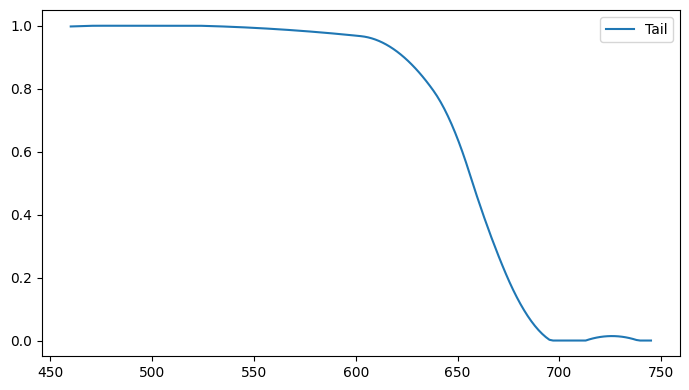

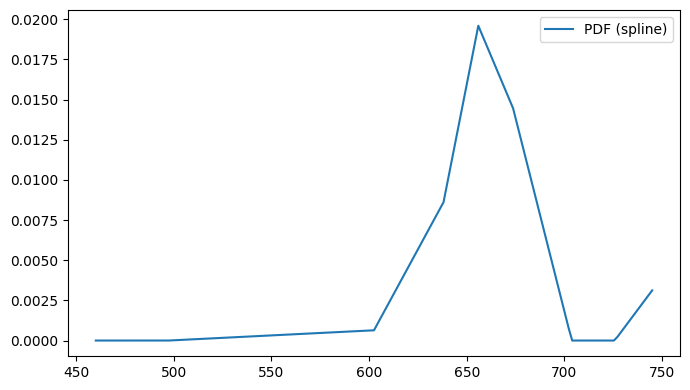

In [54]:
plt.figure(figsize=(7,4)); plt.plot(K, tail, label='Tail'); plt.legend(); plt.tight_layout(); plt.show()
plt.figure(figsize=(7,4)); plt.plot(K, f, label='PDF (spline)'); plt.legend(); plt.tight_layout(); plt.show()

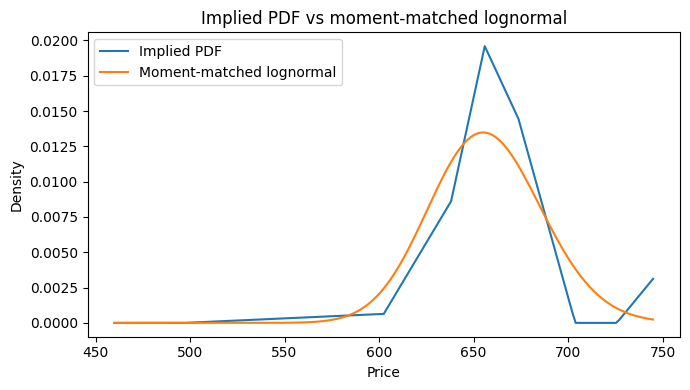

In [55]:
def moment_matched_lognormal(mean, var):
    # Solve for mu, sigma of lognormal such that E[X]=mean, Var[X]=var
    if var <= 0 or mean <= 0:
        return None
    phi2 = var/(mean**2) + 1.0
    sigma2 = math.log(phi2)
    mu = math.log(mean) - 0.5*sigma2
    sigma = math.sqrt(sigma2)
    return mu, sigma

fit = moment_matched_lognormal(mom['mean'], mom['var'])

if fit is not None:
    mu, sig = fit
    from math import sqrt, pi, exp
    def logn_pdf(x):
        x = np.asarray(x)
        with np.errstate(divide='ignore', invalid='ignore'):
            dens = np.exp(-(np.log(x) - mu)**2 / (2*sig**2)) / (x * sig * np.sqrt(2*np.pi))
        dens[~np.isfinite(dens)] = 0.0
        return dens

    f_logn = logn_pdf(K)
    # scale to integrate to 1 on K-range (for overlay fairness)
    f_logn = f_logn / max(1e-12, np.trapz(f_logn, K))
    plt.figure(figsize=(7,4))
    plt.plot(K, f, label='Implied PDF')
    plt.plot(K, f_logn, label='Moment-matched lognormal')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.title('Implied PDF vs moment-matched lognormal')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Lognormal overlay skipped (nonpositive mean/var)."
)


In [56]:
pd.DataFrame({'K':K,'C_raw':C_raw,'C_clean':C_clean}).to_csv('C:/Pcs/Python/new price project/cleaned_chain_v2.csv', index=False)
pd.DataFrame({'K':K,'pdf':f,'tail':tail,'cdf':cdf}).to_csv('C:/Pcs/Python/new price project/implied_pdf_v2.csv', index=False)
print('Saved cleaned_chain_v2.csv and implied_pdf_v2.csv')

Saved cleaned_chain_v2.csv and implied_pdf_v2.csv
